# Sequence Processing with Recurrent Neural Networks

So far, we have seen how word vectors can be constructed from corpus statistics, and how they can be utilized to infer latent semantic content either in isolation (e.g. genders from names) or in relation to one another (e.g. similarities and analogies). 

For tasks involving larger linguistic units such as phrases, sentences and dialogues, we need machinery capable of processing _sequences_ or _structures_ of words.

Recurrent Neural Networks are an example of such machinery; for this assignment, you will construct a recurrent neural network that annotates each word of a sentence with a linguistically informative marker. In the simple case (and in this assignment), these markers will be POS tags. However, they can also be morphosyntactic informative [categories](https://en.wikipedia.org/wiki/Combinatory_categorial_grammar) (supertags).

In both cases, the task is a case of sequence labeling.  A good reference point is Jurafsky and Martin [Chapter 9](https://web.stanford.edu/~jurafsky/slp3/9.pdf). For a fuller view of the picture, a good reference point is Alex Graves' [dissertation](https://www.cs.toronto.edu/~graves/preprint.pdf).

We will take a gradual approach, first inspecting recurrent neural networks, then moving on to data processing using high-grade word vectors before finally moving to the problem at hand. 

---

## Recurrent Neural Networks
Recurrent Neural Networks are a particularly interesting class of neural networks. Unlike standard fully-connected networks, which accept a fixed-size input and produce a fixed-size output over a predefined number of computational steps (i.e. network layers), RNNs instead operate on sequences of vectors. 

Computationally, feedforward networks may be seen as a trainable (but parametrically fixed) function, whereas RNNs act as continuous, stateful programs operating on sequences of inputs. 
Cognitively, this may be viewed as enhancing our system's perceptive and computational abilities with a notion of memory.
In the general case, this statefulness is captured by an intermediate hidden vector which is adjusted throughout the computation, affected by both the immediately previous version of itself __and__ the current input.

RNNs are nowadays established as the core machinery of neural sequence processing. 

A simple recurrent network (SRN or Elman network) is described by the equations:
* $h_t = \theta_h (W_h x_t + U_h h_{t-1} + b_h ) $
* $y_t = \theta_y (W_y h_t + b_y) $

where (at timestep $t$) $x_t$, $h_t$, $y_t$ are the network's input, hidden and output representations respectively, $\theta_h$, $\theta_y$ its hidden and output activation functions, and $W_h$, $U_h$, $b_h$, $W_y$, $b_y$ parametric tensors to be learned.

In [1]:
import torch
from torch import FloatTensor, LongTensor
from typing import Tuple, List, Callable, Optional

### Assignment 2.0: Our own SRN
Let's make our own simple recurrent network from scratch, to get an idea of its inner workings. To make our life just a bit simpler, we will use `torch.nn.Linear` to model the internal transformations.

Complete the `mySRN` class, which is initialized with the input $d_i$, hidden $d_h$ and output $d_o$ dimensionalities, as well as two non-linear functions $\theta_h$ and $\theta_y$, and constructs a SRN implementing three `torch.nn.Linear` layers:
1. `x_to_h`: a layer that takes $x_t$ and produces $W_h x_t$
2. `h_to_h`: a layer that takes $h_{t-1}$ and produces $U_h h_{t-1} + b_h$
3. `h_to_y`: a layer that takes $h_t$ and produces $W_y h_t + b_y$

Implement the function `step` that performs a computational step, accepting $x_t$ and $h_{t-1}$ and producing $h_t$ and $y_t$.

Implement the function forward that accepts a List of inputs $X$, an initial hidden vector $h_{-1}$ and iteratively applies `step` until the input sequence is exhausted, returning a List of outputs $Y$ (of the same length as $X$).

_Hint_: Note that `x_to_h` does not have a bias term $b$, since we will incorporate it into `h_to_h`

In [2]:
class mySRN(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, 
                 hidden_activation: Callable[[FloatTensor], FloatTensor],
                 output_activation: Callable[[FloatTensor], FloatTensor],
                 device: str):
        super(mySRN, self).__init__()
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.device = device
        
        self.x_to_h = torch.nn.Linear(input_dim, hidden_dim, bias=False)
        self.h_to_h = torch.nn.Linear(hidden_dim, hidden_dim)
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim)
        
    def step(self, x: FloatTensor, h: FloatTensor) -> Tuple[FloatTensor, FloatTensor]:
        ht = self.hidden_activation(self.x_to_h(x) + self.h_to_h(h))
        yt = self.output_activation(self.h_to_y(ht))
        return ht, yt
        
    def forward(self, X: List[FloatTensor], h: FloatTensor) -> List[FloatTensor]:
        outputs = []
        ht = h
        for item in X:
            ht, output = self.step(item, ht)
            outputs.append(output)
        return outputs

f = mySRN(3,3,1, hidden_activation=torch.nn.Tanh(), output_activation=torch.nn.Sigmoid(), device='cpu')
X = (torch.rand(3), torch.rand(3), torch.rand(3))
h = torch.rand(3)
y = f(X,h)
# print(y)   used to check the network effectively worked

In practice, we do not need to write our own functions for common RNN architectures. 
Torch already provides the [necessary abstractions](https://pytorch.org/docs/stable/nn.html#recurrent-layers).

The [RNN](https://pytorch.org/docs/stable/nn.html#rnn) wrapper implements highly optimized forward routines to compute the hidden representations of a full input sequence.

Some pointers:
* Unlike our naive implementation, RNN accepts a 3-dimensional tensor of shape (seq_len, batch_shape, input_dim) rather than a list of 2-dimensional tensors
* If no initial hidden state is provided, it defaults to a zero tensor
* The class produces just the RNN hidden states; it is up to us to define the `h_to_y` transformation on top of them
* The non-linearity argument is a string; our only two choices are either `'tanh'` or `'relu'` (shorthands for `torch.nn.Tanh` and `torch.nn.ReLU` respectively)

Read the documentation (!) for further details.

A brief example is given below.

In [3]:
rnn = torch.nn.RNN(input_size=16, hidden_size=48, nonlinearity='tanh')
X = torch.rand(10, 32, 16)
h, _ = rnn(X)
print(h.shape)

torch.Size([10, 32, 48])


So, for a random input tensor of shape (seq_len, batch_size, input_dim), we get back an output tensor of shape (seq_len, batch_size, hidden_dim)

In [4]:
del mySRN, rnn, X, h

### Assignment 2.1: A faster version of the SRN
Now let's wrap an `RNN` into a custom module `myFastSRN` that implements it aside the `h_to_y` transformation.

In [5]:
class fastSRN(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, 
                 hidden_activation: str,
                 output_activation: Callable[[FloatTensor], FloatTensor],
                 device: str):
        super(fastSRN, self).__init__()
        self.output_activation = output_activation
        self.hidden = torch.nn.RNN(input_size=input_dim, hidden_size=hidden_dim, nonlinearity=hidden_activation)
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, X:FloatTensor, h: Optional[FloatTensor]=None) -> FloatTensor:
        return self.output_activation(self.h_to_y(self.hidden(X, h)[0]))

Let's see our new implementation in action. 

Initialize a random input tensor $X$ that would correspond to 32 sequences,  each of length 10, with each item having 16 features, and a `fastSRN` fit to process it, producing 42-dimensional hidden states and 2-dimension output vectors for each sequence item.

Run the SRN on the tensor and make sure the output shape is as expected.

In [6]:
f = fastSRN(16, 42, 2, hidden_activation='tanh', output_activation=torch.nn.Sigmoid(), device='cpu')
X = torch.rand(10,32,16)
print(f(X).shape)


torch.Size([10, 32, 2])


Hopefully everything should be in order.

You may have noticed a minor complication: in order to utilize batching, we need our input sequences to be of the same length.

This however is very rarely the case in practice. A common trick against this problem is _padding_; that is, appending zero tensors to all input sequences shorter than the maximum in-batch length to make them all equally long.

As usual, torch already does the hard work for us via [pad_sequence](https://pytorch.org/docs/stable/nn.html?highlight=pad%20_sequence#torch.nn.utils.rnn.pad_sequence). Given a list of $N$ 2-dimensional tensors, each of shape (seq_len$_n$, input_dim), it will construct a 3-d tensor of shape ($max_{n \in N}${seq_len$_n$}, N, input_dim).

An example:

In [7]:
x_1 = torch.rand(1, 16)  # a sequence of 1, 16-dimensional item
x_2 = torch.rand(7, 16)  # a sequence of 7, 16-dimensional items
x_3 = torch.rand(5, 16)  # a sequence of 5, 16-dimensional items

X = torch.nn.utils.rnn.pad_sequence([x_1, x_2, x_3])  

# Can you guess what the shape of X is?
print(X.shape)

torch.Size([7, 3, 16])


In [8]:
del x_1, x_2, x_3, X

## Pretrained Word Embeddings
Moving on-- last assignment, we saw how to train our own word embeddings using a miniature toy corpus. Now, we will see how to easily employ high-quality pretrained word vectors and, later on, how to utilize them for further downstream tasks.

We are going to use [spaCy](https://spacy.io/). SpaCy is a high-level NLP library that provides a ton of useful functionalities, but we will only focus on its pretrained embeddings for this assignment.

Before proceeding, [install spacy](https://spacy.io/usage) using your python package manager (e.g. `pip install spacy`).

In [9]:
import spacy

SpaCy comes with a lot of different-size models for different languages. 

We will need to download the small english model for the exercises to follow. You can either do it on a new terminal window (optimal, if you are running this assignment through a virtual environment) or by simply running the magic command below. 

In [10]:
!python3 -m spacy download en_core_web_lg

Python was not found but can be installed from the Microsoft Store: https://go.microsoft.com/fwlink?linkID=2082640


After having downloaded the model, we can load it as follows (you may need to restart your notebook after the download is complete):

In [11]:
nlp = spacy.load('en_core_web_lg')

We can then use the loaded model to process a sentence and obtain its word vectors, a List of 300-dimensional numpy arrays.

In [12]:
doc = nlp('this is a sentence of 7 words')  # the processed sentence
vectors = list(map(lambda x: x.vector, doc))  # its vectors
print('We have {} vectors..'.format(len(vectors)))
print('..each of shape {}'.format(vectors[0].shape))

We have 7 vectors..
..each of shape (300,)


And then finally convert them into torch tensors.

In [13]:
torch_vectors = torch.tensor(vectors)
print(torch_vectors.shape)

torch.Size([7, 300])


Or, in the case of multiple sentences:

In [14]:
# Example sentences
sentences = ['This is a sentence', 'This is another sentence.']

# Parallel processing with spacy
docs = list(map(nlp, sentences))

# Convert each processed sentence into a list of vectors
vectors = map(lambda doc: [word.vector for word in doc], docs)

# Convert each list of vectors into a 2-d torch tensor
tensors = list(map(lambda sentence_vectors: torch.tensor(sentence_vectors), vectors))

## POS Tagging
Given our pretrained embeddings, we may represent sentences as _sequences of vectors_, which is exactly the format expected by an RNN.
We will now try to train an SRN to iterate over a sentence and assign part of speech tags to each of its words.

### Assignment 2.2: Why use an RNN?
In the context of POS tagging, what is the advantage of using a recurrent network over a feedforward network that processes each word individually?

In natural language, the meaning of a word is not usually the same in all words, but can differ based on its context in a sentence. By looking at words in the sequence in which they occur in a sentence, the temporal relationships in this context can be taken into account. These relationships cannot be captured by a feedforward network, but can be captured by a recurrent network. This makes the use of a recurrent network more advantageous.


First, let's load and inspect our datafiles.

The pickle file contains three items:
1. `sentences`: a List of strings (-sentences)
1. `postags`: a List of Lists of strings (-POS tags)
2. `pos_to_int`: a Dictionary from strings to ints (mapping each POS tag to a unique identifier)
 

In [15]:
import pickle
with open('TRAIN.p', 'rb') as f:
    sentences, postags, pos_to_int = pickle.load(f)

In [16]:
#same for the test set
with open('TEST.p', 'rb') as f_test:
    sentences_test, postags_test, pos_to_int_test = pickle.load(f_test)

Now, let us take a moment to understand the data a bit more. 
The POS tags in this dataset are in the style of the Penn Treebank. Find the top 20 most common tags and plot a histogram of their frequencies. Find out what these tags mean linguisically! https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [17]:
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np

flattened = [val for sublist in postags for val in sublist if val != '.' and val != ',']
most_freq = Counter(flattened)
top_20_pairs = most_freq.most_common(20)
top_20 = [i[0] for i in top_20_pairs]

indices = np.arange(len(top_20))
plt.bar(indices, [i[1] for i in top_20_pairs], color='r')
plt.xticks(indices, top_20, rotation='vertical')
plt.tight_layout()
plt.show()


<Figure size 640x480 with 1 Axes>

Next, we need to convert our data to numeric form.

### Assignment 2.3: Tensorizing sentences
Convert sentences to their tensor format, as done earlier (this may take a while). 

<div class="alert alert-block alert-warning">
<b>Important!</b>
Since the sentences are pre-tokenized (i.e. they are provided as sequences of words rather than strings), we need to change the processing call to ensure the output vectors are aligned with our tokenization.
</div>

In [18]:
docs = list(map(lambda sentence: 
                spacy.tokens.doc.Doc(nlp.vocab, words=sentence.split()), 
            sentences))

doc_vectors = map(lambda doc: [word.vector for word in doc], docs)

doc_tensors = list(map(lambda sentence_vectors: torch.tensor(sentence_vectors), doc_vectors))

# We no longer need the docs and numpy array
del doc_vectors, docs

In [19]:
# same for the test set
docs_test = list(map(lambda sentence: 
                spacy.tokens.doc.Doc(nlp.vocab, words=sentence), 
            sentences_test))

doc_vectors_test = map(lambda doc: [word.vector for word in doc], docs_test)

doc_tensors_test = list(map(lambda sentence_vectors: torch.tensor(sentence_vectors), doc_vectors_test))

# We no longer need the docs and numpy array
del doc_vectors_test, docs_test

Similarly, we will use `pos_to_int` to convert the POS sequences into tensors.

In [20]:
pos_numeric = list(map(lambda pos_sequence: [pos_to_int[pos] for pos in pos_sequence], postags))
pos_tensors =  list(map(lambda pos_num_sequence: torch.tensor(pos_num_sequence), pos_numeric))

In [21]:
# same for the test set
pos_tensors_test =  list(map(lambda pos_num_sequence: torch.tensor(pos_num_sequence), postags_test))

In the first assignment, we saw how to split our dataset into a training and a validation set. 

Do the same here, splitting the sentences, postags and their corresponding tensors into a training and a validation set.

In [22]:
from sklearn.model_selection import train_test_split
sentences_train, sentences_val, postags_train, postags_val, X_train, X_val, Y_train, Y_val \
    = train_test_split(sentences, postags, doc_tensors, pos_tensors, test_size=0.2)
assert len(X_train) == len(Y_train) == len(sentences_train)
assert len(X_val) == len(Y_val) == len(sentences_val)

In [23]:
X_test = doc_tensors_test
Y_test = pos_tensors_test

Again, following along the first assignment, we will wrap our tensors into a `Dataset` and a `DataLoader`.

Since our data are not Tensors but rather Lists of Tensors of uneven lengths, we need to write our own Dataset wrapper.
The wrapper only needs to implement two functions; `__len__`, which expects no arguments and returns the number of samples in the dataset, and `__getitem__`, which accepts an index `idx` and returns the input-output pair `X[idx]`, `Y[idx]`.

Similarly, the Dataloader needs to process the list of input-output pairs produced by the Dataset using `pad_sequence`, as seen earlier.

### Assignment 2.4: Padding
#### a) What is the advantage to applying padding on the batch rather than the entire dataset?

Given that padding changes the sequences so they are all the same length as the longest sequence, doing this for the entire data set changes the lengths of all sequences to the length of the longest sequence of the overall data set. If this is a particularly large sequence, then a lot of space is unnecessarily used for the padding of the other sequences. When applying padding to batches, this extensive padding for the longest sequence will only be applied to that one batch.

#### b) Fill in the code for `UnevenLengthDataset` class, implementing its two core functions.

Then, complete the function `pad_batch` which takes a list of (x$_i$, y$_i$) pairs and produces the pair of their paddings: (X, Y).

Given the two, the `DataLoader` object defined can iterate over the Dataset yielding uniform batches ready to be consumed by an RNN.

In [24]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader


class UnevenLengthDataset(Dataset):
    def __init__(self, X: List[FloatTensor], Y: List[LongTensor]) -> None:
        self.X = X
        self.Y = Y
        
    def __len__(self) -> int:
        return len(self.X)
        
    def __getitem__(self, idx: int) -> Tuple[FloatTensor, LongTensor]:
        return (self.X[idx], self.Y[idx])
    
    
def pad_batch(batch: List[Tuple[FloatTensor, LongTensor]]) -> Tuple[FloatTensor, LongTensor]:
    padded_X = torch.nn.utils.rnn.pad_sequence([i[0] for i in batch], batch_first=False) #unsure if this should be true
    padded_Y = torch.nn.utils.rnn.pad_sequence([i[1] for i in batch], batch_first=False) #unsure if this should be true
    padded_pair = (padded_X, padded_Y)
    return padded_pair
                  
train_dataset = UnevenLengthDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, 
                              collate_fn=pad_batch,
                              shuffle=True,
                              batch_size=32)

val_dataset = UnevenLengthDataset(X_val, Y_val)
val_dataloader = DataLoader(val_dataset,
                            collate_fn=pad_batch,
                            shuffle=False,
                            batch_size=32)

test_dataset = UnevenLengthDataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset,
                            collate_fn=pad_batch,
                            shuffle=False,
                            batch_size=32)

What does a batch look like, shape-wise?

In [25]:
for batch_x, batch_y in train_dataloader:
    print(batch_x.shape)
    print(batch_y.shape)
    break

torch.Size([54, 32, 300])
torch.Size([54, 32])


So far so good. On to the network.

### Assignment 2.5: Utility Functions
Remember how we defined our training and validation functions for the first assignment?

You will need to do the same here.
Note that while you can use the given code as a guideline, just copying it won't do the trick; unlike a feedforward net, a recurrent network produces a 3rd order output tensor, of shape (max_seq_len, batch_size, num_output_classes).

Similarly, our target Y is a 2nd order tensor of shape (max_seq_len, batch_size).

You will need to properly treat the extra dimensional of both the output and the target, since loss functions expect an order 2 output tensor and an order 1 target tensor. 

Complete the functions `train_batch`, `train_epoch`, `eval_batch` and `eval_epoch`.

In [26]:
def accuracy(predictions: LongTensor, truth: LongTensor, ignore_idx: int) -> Tuple[int, int]:
    """
        Given a tensor containing the network's predictions and a tensor containing the true values, as well
        as an output value to ignore (e.g. the padding value), computes and returns the total count of non-
        ignored values as well the total count of correctly predicted values.
        
        predictions: The network's predictions.
        truth: The true output labels.
        ignore_idx: The output padding value, to be ignored in accuracy calculation.
    """
    
    correct_words = torch.ones(predictions.size())
    correct_words[predictions != truth] = 0
    correct_words[truth == ignore_idx] = 1

    num_correct_words = correct_words.sum().item()
    num_masked_words = len(truth[truth == ignore_idx])

    return predictions.shape[0] * predictions.shape[1] - num_masked_words, num_correct_words - num_masked_words


def measure_accuracy(network: torch.nn.Module,
                    dataloader: DataLoader,
                    device: str) -> float:
    """
        Given a network, a dataloader and a device, iterates over the dataset and returns the network's accuracy.
    """
    correct = 0
    total = 0
    for x_batch, y_batch in dataloader:
        pred = network(x_batch.to(device))
        local_total, local_correct = accuracy(pred.argmax(dim=-1), y_batch.to(device), ignore_idx=0)
        correct+= local_correct
        total+= local_total
    return correct/total
    

def train_batch(network: torch.nn.Module,
                X_batch: FloatTensor,
                Y_batch: LongTensor,
                loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],  
                optimizer: torch.optim.Optimizer) -> float:
    
    network.train()
    prediction_batch = network(X_batch)  # forward pass
    prediction_batch_reshaped = prediction_batch.view(prediction_batch.shape[0]*prediction_batch.shape[1], prediction_batch.shape[2])
    Y_batch_reshaped = Y_batch.view(Y_batch.shape[0]*Y_batch.shape[1])
    batch_loss = loss_fn(prediction_batch_reshaped, Y_batch_reshaped)  # loss calculation
    batch_loss.backward()  # gradient computation
    optimizer.step()  # back-propagation
    optimizer.zero_grad()  # gradient reset
    return batch_loss.item()

def train_epoch(network: torch.nn.Module, 
                dataloader: DataLoader,
                loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
                optimizer: torch.optim.Optimizer, 
                device: str) -> float:
    
    loss = 0.
    for i, (x_batch, y_batch) in enumerate(dataloader):
        loss += train_batch(network=network, X_batch=x_batch, Y_batch=y_batch, loss_fn=loss_fn, optimizer=optimizer)
    loss /= (i+1) # divide loss by number of batches for consistency 
    return loss

def eval_batch(network: torch.nn.Module,
                X_batch: FloatTensor,
                Y_batch: LongTensor,
                loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor]) -> float:
    
    network.eval()
    
    with torch.no_grad():
        prediction_batch = network(X_batch)  # forward pass
        prediction_batch_reshaped = prediction_batch.view(prediction_batch.shape[0]*prediction_batch.shape[1], prediction_batch.shape[2])
        Y_batch_reshaped = Y_batch.view(Y_batch.shape[0]*Y_batch.shape[1])
        batch_loss = loss_fn(prediction_batch_reshaped, Y_batch_reshaped)  # loss calculation
        return batch_loss.item()

def eval_epoch(network: torch.nn.Module, 
                # a list of data points x
                dataloader: DataLoader,
                loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor],
                device: str) -> float:
    
    loss = 0.
    for i, (x_batch, y_batch) in enumerate(dataloader):
        loss += eval_batch(network, x_batch, y_batch, loss_fn)
    loss /= (i+1) # divide loss by number of batches for consistency 
        
    return loss

### Assignment 2.6: SRN POS tagging
Define a simple recurrent network, with input size compatible with the vector dimensionality, output size compatible with the number of output classes (the number of different POS tags + 1) and a hidden size of your own choice. What is a reasonable choice?

#### a) Why do we need to add 1 to the number of output classes?

Because the padding added 0 values to the ends of sequences, an additional output is required to differentiate the padded values from the original sequence entries.

#### b) Implementation

Use `"tanh"` as your hidden layer activation, and choose **an appropriate combination of output activation and loss function** (consider the task at hand, and refer to the documentation if in doubt- refer to tutorial as well!).

Then instantiate an optimizer over your network, and train it for a number of epochs, measuring and printing all metrics in the process (train and validation loss and accuracy).

_Hint_: Use `measure_accuracy` (defined earlier) to obtain accuracy.

Plot the loss curves over the training process.

In [27]:
I = 300
H = 150
O = len(pos_to_int) + 1
srn = fastSRN(I,H,O, 'tanh', torch.nn.LogSoftmax(dim=2), 'cpu')
opt = torch.optim.Adam(srn.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [28]:
# The following code was used to tune the network parameters

import time
device = 'cpu'
NUM_EPOCHS = 10

# train_losses = []
# val_losses = []
# train_accs = []
# val_accs = []

# start_time = time.time()
# for t in range(NUM_EPOCHS):
#     train_loss = train_epoch(srn, train_dataloader, optimizer=opt, loss_fn=loss_fn, device=device)
#     val_loss = eval_epoch(srn, val_dataloader, loss_fn, device=device)
#     train_acc = measure_accuracy(srn, train_dataloader, device=device)
#     val_acc = measure_accuracy(srn, val_dataloader, device=device)
    
#     print('Epoch {}'.format(t))
#     print(' Training Loss: {}'.format(train_loss))
#     print(' Validation Loss: {}'.format(val_loss))
#     print(' Training Accuracy: {}'.format(train_acc))
#     print(' Validation Accuracy: {}'.format(val_acc))
#     print('Elapsed time: ', time.time() - start_time)
    
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     train_accs.append(train_acc)
#     val_accs.append(val_acc)

In [29]:
# after having tuned the parameters the final accuracy is calculated on the test set
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for t in range(NUM_EPOCHS):
    train_loss = train_epoch(srn, train_dataloader, optimizer=opt, loss_fn=loss_fn, device=device)
    test_loss = eval_epoch(srn, test_dataloader, loss_fn, device=device)
    train_acc = measure_accuracy(srn, train_dataloader, device=device)
    test_acc = measure_accuracy(srn, test_dataloader, device=device)
    
    print('Epoch {}'.format(t))
    print(' Training Loss: {}'.format(train_loss))
    print(' Test Loss: {}'.format(test_loss))
    print(' Training Accuracy: {}'.format(train_acc))
    print(' Test Accuracy: {}'.format(test_acc))
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

Epoch 0
 Training Loss: 0.3546352991501227
 Test Loss: 0.1426519439758166
 Training Accuracy: 0.9154456791229799
 Test Accuracy: 0.9143974817395556
Epoch 1
 Training Loss: 0.12127474236567289
 Test Loss: 0.11183111102360746
 Training Accuracy: 0.9316564357618664
 Test Accuracy: 0.9296476269062681
Epoch 2
 Training Loss: 0.10030973400698592
 Test Loss: 0.10012673157388749
 Training Accuracy: 0.9400147862711713
 Test Accuracy: 0.9354542954066196
Epoch 3
 Training Loss: 0.08887174453660353
 Test Loss: 0.0945266394511513
 Training Accuracy: 0.9440156674731905
 Test Accuracy: 0.9379908926988784
Epoch 4
 Training Loss: 0.08179662514798688
 Test Loss: 0.089513817154195
 Training Accuracy: 0.9487166562117274
 Test Accuracy: 0.9409553497753737
Epoch 5
 Training Loss: 0.07635898741566582
 Test Loss: 0.08796814667141956
 Training Accuracy: 0.9519539534605849
 Test Accuracy: 0.9427584731517985
Epoch 6
 Training Loss: 0.0714244995142845
 Test Loss: 0.08570860366782417
 Training Accuracy: 0.95473384

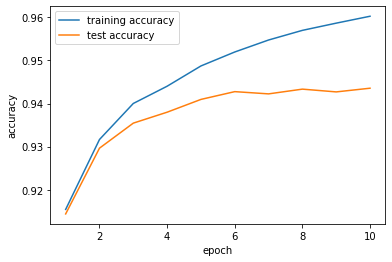

In [30]:
# Plotting of the accuracy

# naming the x axis 
plt.xlabel('epoch') 
# naming the y axis 
plt.ylabel('accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), train_accs, label = 'training accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_accs, label = 'test accuracy')
plt.legend()

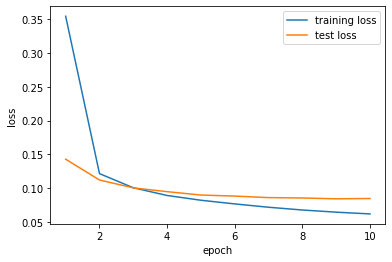

In [31]:
# Plotting of the loss

# naming the x axis 
plt.xlabel('epoch') 
# naming the y axis 
plt.ylabel('loss')
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label = 'training loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label = 'test loss')
plt.legend()

The test accuracy on this task should be well over 90%. If you are getting an accuracy much below this, play with your hyperparameters and try to improve. 

#### c) What is your final accuracy?

94.2%

#### d) A little error analysis
Minimally, find a few instances of sentences with wrong tags. Can you say why these mistakes are made?
Optionally, feel free is do a full error analysis. What are the most commonly confused tags for an English POS tagger?

In [32]:
import random

int_to_pos = [(v, k) for k, v in pos_to_int.items()]
int_to_pos.insert(0, (0, 'PAD'))
int_to_pos.sort()
int_to_pos = dict(int_to_pos)

# indexes = random.sample(range(len(sentences)), 5)  # used to find sentences
indexes = list([11823, 14963, 6589])

for idx in indexes:
    test_sentence = sentences[idx]
    true_tags = postags[idx]

    test_doc = nlp(test_sentence)  # the processed sentence
    test_vectors = list(map(lambda x: x.vector, test_doc))  # its vectors
    test_vectors = torch.FloatTensor(test_vectors).unsqueeze(0)

    values = srn(test_vectors).squeeze(0)
    values_list = list(map(lambda x: x.argmax(dim=0).item(), values))

    print(test_sentence)
    print()
    print(*true_tags, sep = "  ")
    print()
    for value, comp in zip(values_list, true_tags):
        pos = int_to_pos.get(value)
        if pos != comp:
            print(pos, " ", end = '')
        else:
            print(pos, " ", end = '')
    print('\n' * 3)


Regular TV series ratings have slumped in the past five years , and premiering new shows is a crap shoot , Mr. Pilson says .

JJ  NN  NN  NNS  VBP  VBN  IN  DT  JJ  CD  NNS  ,  CC  VBG  JJ  NNS  VBZ  DT  NN  NN  ,  NNP  NNP  VBZ  .

JJ  NNP  NNP  NNS  VBP  VBD  IN  DT  JJ  CD  NNS  ,  CC  VBG  NNP  VBZ  VBZ  DT  NN  PRP  ,  NNP  NNP  VBZ  .  



But Mr. Zoeller also acknowledges that consultants can be very effective .

CC  NNP  NNP  RB  VBZ  IN  NNS  MD  VB  RB  JJ  .

CC  NNP  NNP  RB  VBZ  DT  NNS  MD  VB  RB  JJ  .  



Sen. Dole also said he hoped for unanimous support for a resolution he plans to offer tomorrow denouncing the Nicaraguan leader .

NNP  NNP  RB  VBD  PRP  VBD  IN  JJ  NN  IN  DT  NN  PRP  VBZ  TO  VB  NN  VBG  DT  JJ  NN  .

NNP  NNP  RB  VBD  PRP  VBD  IN  JJ  NN  IN  DT  NNP  PRP  NNS  TO  NN  NN  VBG  DT  JJ  NN  .  





The code above gives a few sentences, their tags as given by the database, and the tags generated by the RNS made for this assignment.

In multiple cases the RNS has issues correctly classifying different forms of nouns. For example, in the first sentence, the word 'series', and in the last sentence the word 'resolution' is classified as a proper noun instead of a singular common noun.
This is quite understandable as nouns and proper nouns are used almost identically in sentence structure. The most significant difference is the fact that proper nouns are always capitalized, but because common nouns are also capitalized when at the beginning of a sentence this can be hard to learn.

Similar mistakes are made in the first sentence, where verbs being falsely classified as different kinds of verbs. The word 'slumped' is tagged as a past tense verb, instead of a past participle verb. The time (past tense) was properly identified, but the nuanced differences between these types of words are hard to catch.

There are also a few examples where nouns are classified as verbs and vice-versa. Examples of these are the words 'shows' and 'plans'. All of these words can be either verbs or nouns depending on the context. While a RNS should be able to find some of these differences due to being more aware of temporal relationships of words in sentences, this does not seem to work perfectly.

The interpretations of temporal relationships could also lead to some errors. In the first sentence, the word 'new' gets tagged as a proper noun instead of as an adjective. This is likely because it is more common to have some type of noun right after a verb. In the second sentence, the word 'that' is tagged as a determiner instead of as a preposition. This is likely because often after a connective type of word a determiner is given to describe the relation between a verb and what comes next, instead of a preposition.

The misidentification of 'premiering', classified as an adjective, is hard to explain, but coherent with the classification of 'new' as a noun and 'shows' as a verb.

The classification of 'shoot' as a personal pronoun cannot be explained in linguistic terms.